In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
def plt_plot(y_real):
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    ax.plot(range(len(y_real)),y_real, color='b')
    plt.show()
def plt_plot_2(y_real,y_predicted):
    fig = plt.figure(figsize=(16,12))
    ax = fig.add_subplot(1, 1, 1)
    ax.bar(range(len(y_real)),y_real, color='r',)
    ax.plot(range(len(y_predicted)),y_predicted, color='b')
    plt.ylim(0.85,1.01)
    plt.show()

In [3]:
from sklearn import preprocessing
from sklearn.model_selection import KFold, RepeatedKFold
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [4]:
df_train=pd.read_csv("E:\\jinnan\\train_after_clean.csv")
df_train=df_train[df_train['yield_rate']>=0.87]
df_train.drop(['B3', 'B13', 'A13', 'A18', 'A23'], axis=1, inplace=True)
for col in df_train.columns:
    rate = df_train[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.9:
        df_train.drop(columns=[col], axis=1, inplace=True)
label_array=df_train["yield_rate"].values
df_train["id"]=df_train['id'].apply(lambda x: int(x[7:]))
df_train.drop(columns=['yield_rate'],axis=1,inplace=True)
train_array=df_train.values
print(df_train.columns,df_train.shape)
# min_max_scaler = preprocessing.MinMaxScaler()
# train_array = min_max_scaler.fit_transform(train_array)

df_test=pd.read_csv("E:\\jinnan\\test_after_clean.csv")
df_test.drop(['B3', 'B13', 'A13', 'A18', 'A23'], axis=1, inplace=True)
for col in df_test.columns:
    rate = df_test[col].value_counts(normalize=True, dropna=False).values[0]
    if rate > 0.9:
        df_test.drop(columns=[col], axis=1, inplace=True)
print(df_test.columns,df_test.shape)
columns_list=list(df_test.columns)
# columns_list.remove("id")
sample_id=df_test["id"]
df_test["id"]=df_test['id'].apply(lambda x: int(x[7:]))
test_array=df_test[columns_list].values
# min_max_scaler = preprocessing.MinMaxScaler()
# test_array = min_max_scaler.fit_transform(test_array)

Index(['id', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A14', 'A15',
       'A16', 'A17', 'A19', 'A20', 'A21', 'A22', 'A24', 'A25', 'A26', 'A27',
       'A28', 'B1', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12',
       'B14', 'B10range', 'B11range', 'B9range', 'B4range', 'A20range',
       'A28range'],
      dtype='object') (1383, 39)
Index(['id', 'A5', 'A6', 'A7', 'A8', 'A9', 'A10', 'A11', 'A12', 'A14', 'A15',
       'A16', 'A17', 'A19', 'A20', 'A21', 'A22', 'A24', 'A25', 'A26', 'A27',
       'A28', 'B1', 'B4', 'B5', 'B6', 'B7', 'B8', 'B9', 'B10', 'B11', 'B12',
       'B14', 'B10range', 'B11range', 'A20range', 'B9range', 'B4range',
       'A28range'],
      dtype='object') (150, 39)


In [6]:
xgb_params = {'eta': 0.005, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8,
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 4}
folds = KFold(n_splits=5, shuffle=True, random_state=2018)
oof_xgb = np.zeros(len(df_train))
predictions_xgb = np.zeros(len(df_test))
for fold_, (trn_idx, val_idx) in enumerate(folds.split(train_array, label_array)):
    print("fold n°{}".format(fold_ + 1))
    trn_data = xgb.DMatrix(train_array[trn_idx], label_array[trn_idx])
    val_data = xgb.DMatrix(train_array[val_idx], label_array[val_idx])

    watchlist = [(trn_data, 'train'), (val_data, 'valid_data')]
    clf = xgb.train(dtrain=trn_data, num_boost_round=20000, evals=watchlist, early_stopping_rounds=200,
                    verbose_eval=100, params=xgb_params)
    oof_xgb[val_idx] = clf.predict(xgb.DMatrix(train_array[val_idx]), ntree_limit=clf.best_ntree_limit)
    predictions_xgb += clf.predict(xgb.DMatrix(test_array), ntree_limit=clf.best_ntree_limit) / folds.n_splits

print("CV score: {:<8.8f}".format(mean_squared_error(oof_xgb, label_array)))

fold n°1
[0]	train-rmse:0.422864	valid_data-rmse:0.423725
Multiple eval metrics have been passed: 'valid_data-rmse' will be used for early stopping.

Will train until valid_data-rmse hasn't improved in 200 rounds.
[100]	train-rmse:0.256978	valid_data-rmse:0.257346
[200]	train-rmse:0.15665	valid_data-rmse:0.156573
[300]	train-rmse:0.096109	valid_data-rmse:0.095735
[400]	train-rmse:0.059627	valid_data-rmse:0.059259
[500]	train-rmse:0.037646	valid_data-rmse:0.0376
[600]	train-rmse:0.024455	valid_data-rmse:0.025022
[700]	train-rmse:0.016534	valid_data-rmse:0.017961
[800]	train-rmse:0.011854	valid_data-rmse:0.014328
[900]	train-rmse:0.009082	valid_data-rmse:0.012631
[1000]	train-rmse:0.007447	valid_data-rmse:0.011904
[1100]	train-rmse:0.006402	valid_data-rmse:0.011616
[1200]	train-rmse:0.005686	valid_data-rmse:0.011527
[1300]	train-rmse:0.005159	valid_data-rmse:0.011537
[1400]	train-rmse:0.00473	valid_data-rmse:0.011577
Stopping. Best iteration:
[1212]	train-rmse:0.005617	valid_data-rmse:0.

In [18]:
np.mean(label_array-oof_xgb)

0.0007345900323196211

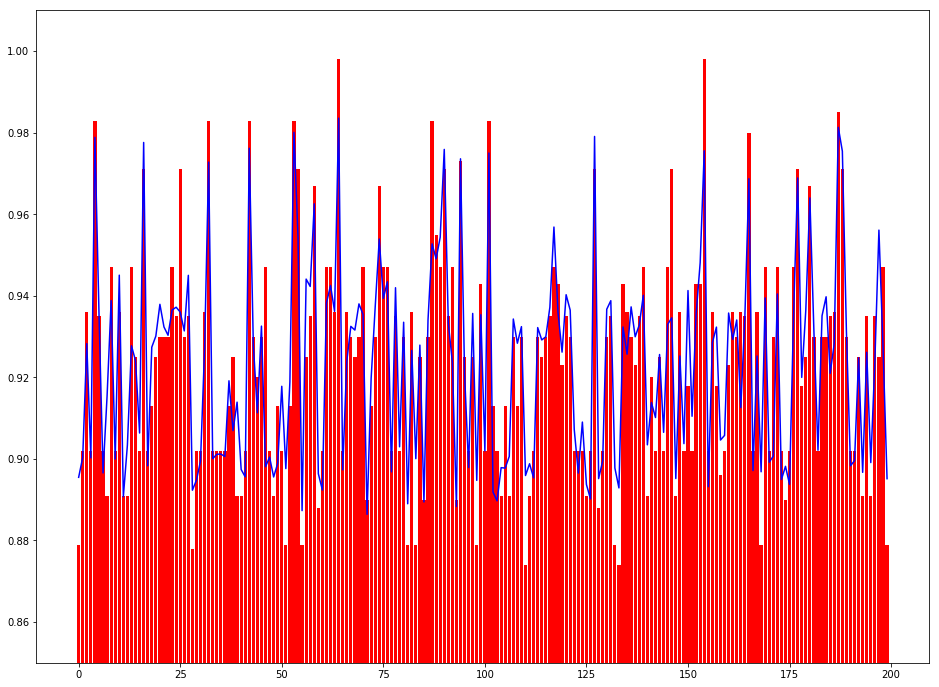

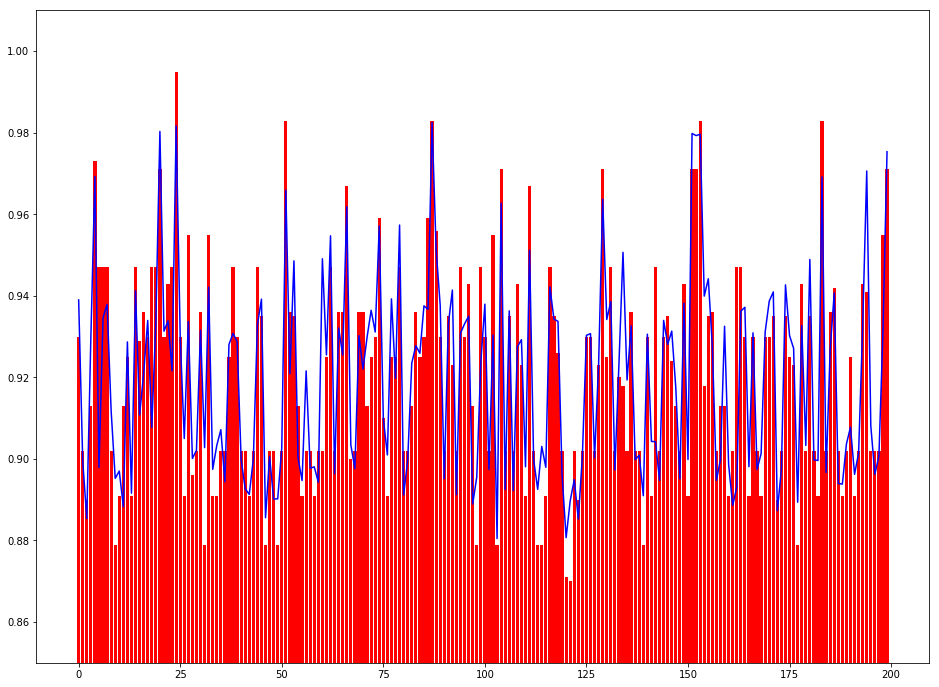

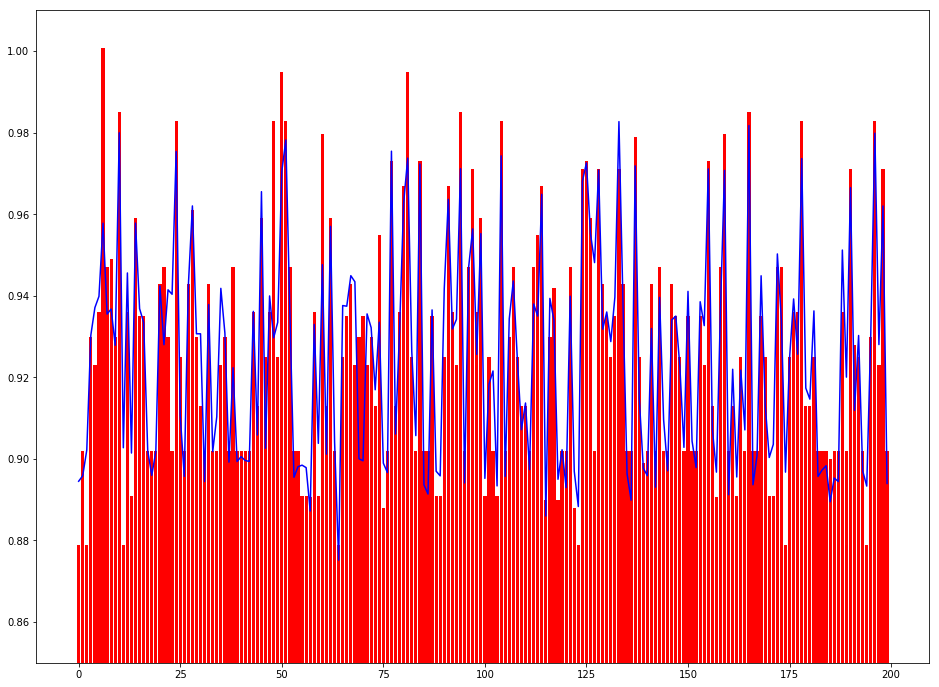

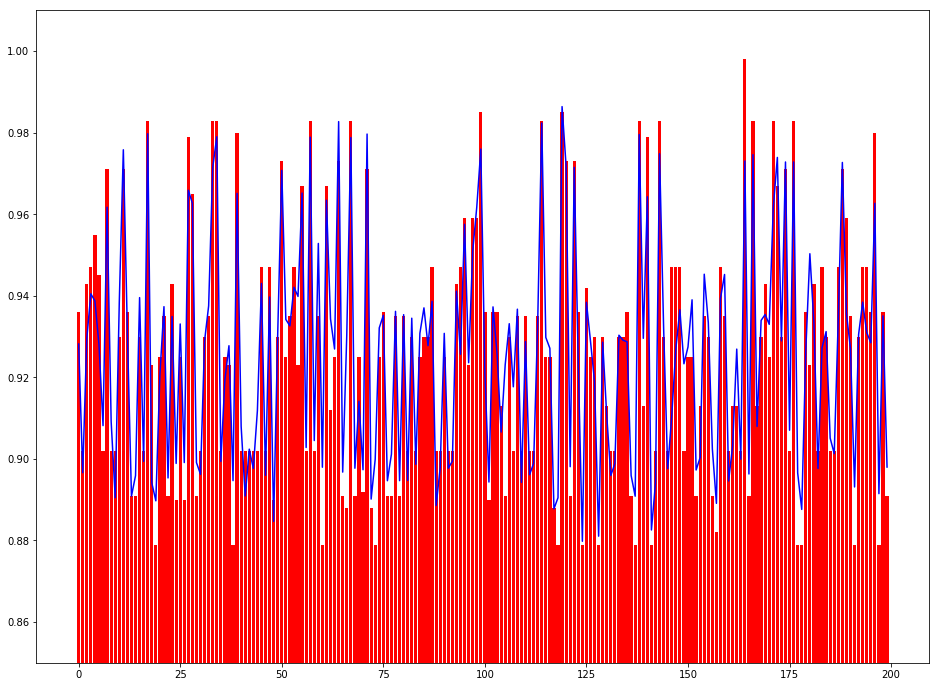

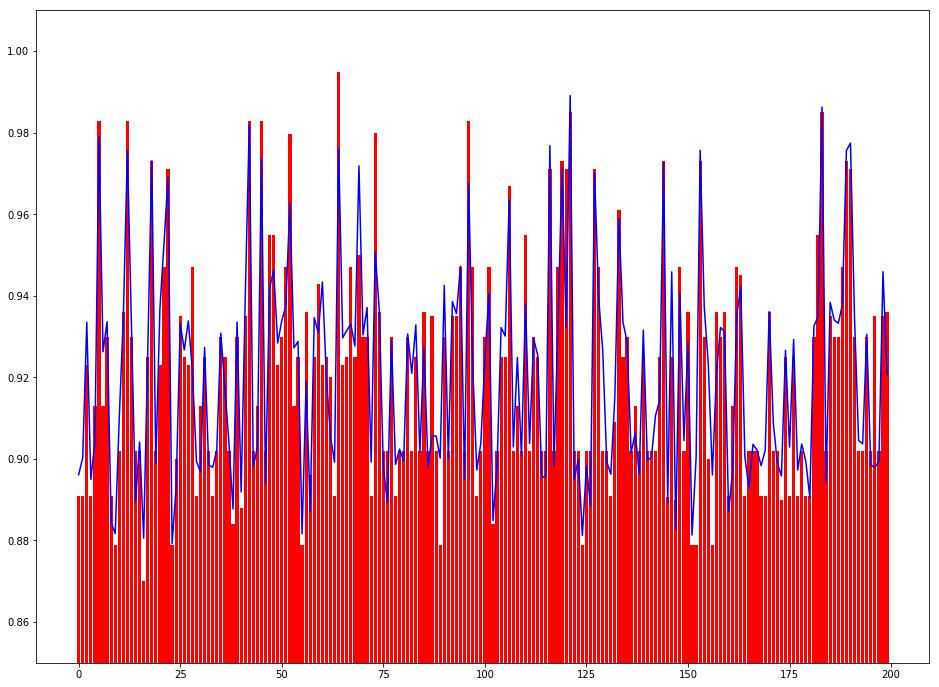

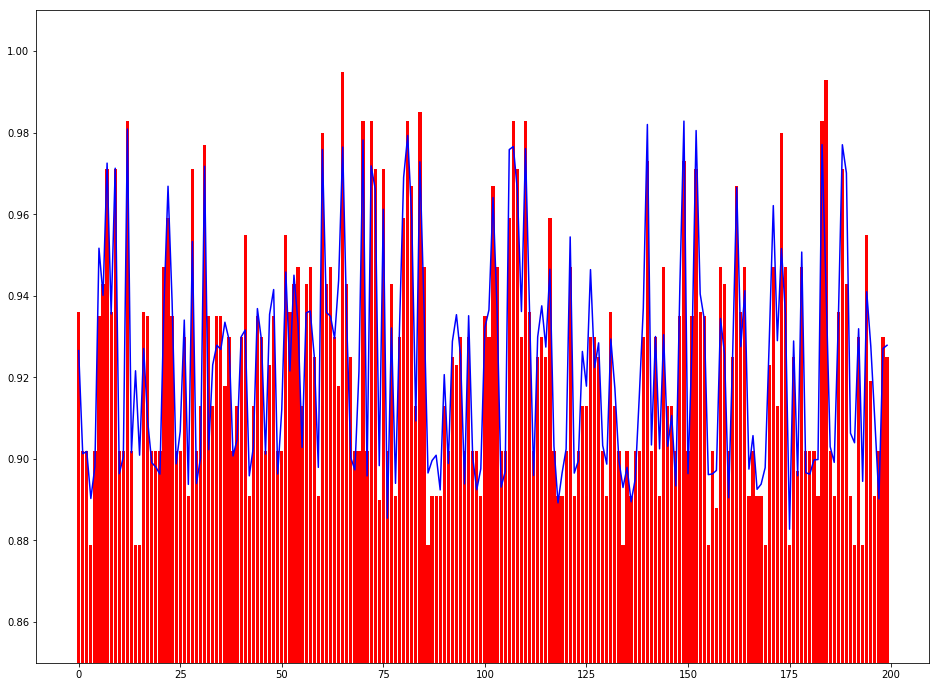

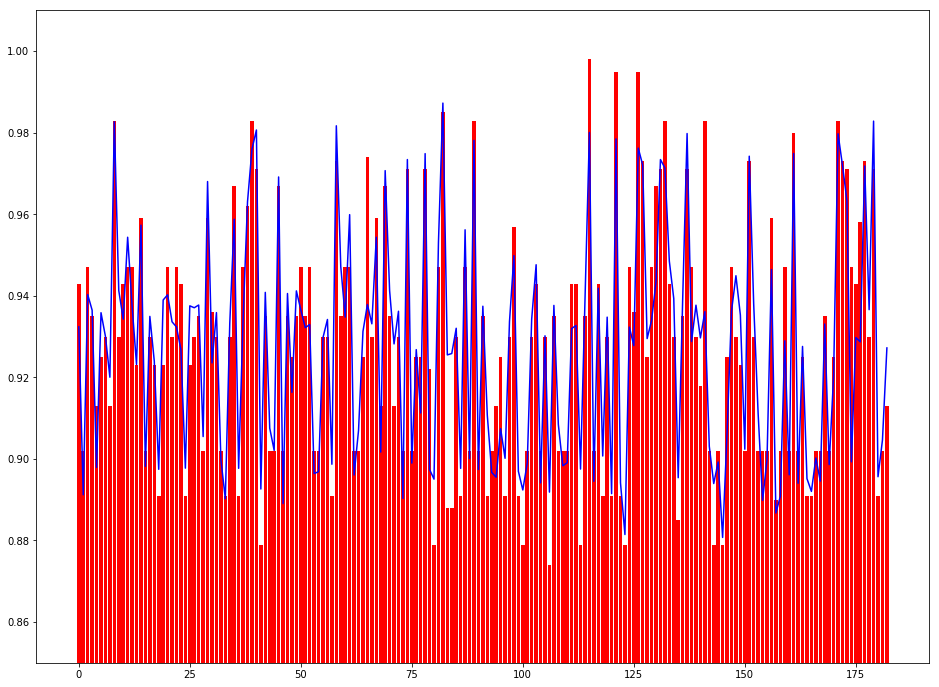

In [19]:
plt_plot_2(label_array[0:200],oof_xgb[0:200])
plt_plot_2(label_array[200:400],oof_xgb[200:400])
plt_plot_2(label_array[400:600],oof_xgb[400:600])
plt_plot_2(label_array[600:800],oof_xgb[600:800])
plt_plot_2(label_array[800:1000],oof_xgb[800:1000])
plt_plot_2(label_array[1000:1200],oof_xgb[1000:1200])
plt_plot_2(label_array[1200:],oof_xgb[1200:])

In [7]:
print(np.mean(label_array))
print(np.var(label_array))
print(np.mean(predictions_xgb))
print(np.var(predictions_xgb))

0.9241989877078813
0.0008094887336101163
0.9235061068336169
0.0006824051086274259


In [36]:
df_predicted=pd.DataFrame({"id":sample_id.values,"predicted":predictions_xgb})
df_predicted.loc[:,"predicted"]=df_predicted["predicted"].apply(lambda x: round(x,3))
df_predicted.to_csv("E:\\jinnan\\predict_result\\jinnan_idfea_xgb_1_9.csv",header=None,index=False)
df_predicted

,id,predicted
0,sample_1656,0.900
1,sample_1548,0.879
2,sample_769,0.937
3,sample_1881,0.899
4,sample_1807,0.923
5,sample_145,0.921
6,sample_1212,0.929
7,sample_944,0.899
8,sample_829,0.941
9,sample_616,0.922


In [5]:
xgb_params = {'eta': 0.005, 'max_depth': 10, 'subsample': 0.8, 'colsample_bytree': 0.8,
          'objective': 'reg:linear', 'eval_metric': 'rmse', 'silent': True, 'nthread': 4}
clf=xgb.XGBRegressor(params=xgb_params)
clf.fit(train_array,label_array)
predictions_xgb=clf.predict(test_array)

df_predicted=pd.DataFrame({"id":df_test["id"].values,"predicted":predictions_xgb})
df_predicted.loc[:,"predicted"]=df_predicted["predicted"].apply(lambda x: round(x,3))
# df_predicted.to_csv("E:\\jinnan\\predict_result\\jinnan_xgb_1_9.csv",header=None,index=False)
np.mean(df_predicted)

id           1008.373333
predicted       0.925953
dtype: float64